This Jupyter Notebook was made by Gabriel Sarrazin for the DSI Instructor Challenge


# Part 1: Modeling challenge

##Python Coding and Data Set

In [63]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

###Load in the data file and header file provided

The dataframe does not currently have a header, load in the header file and attach it to the dataframe




In [64]:
col_names = open("field_names.txt", 'r').read().split('\n')

In [65]:
df_cancer = pd.read_csv("breast-cancer.csv", names = col_names)

###Comment on any steps you might take to evaluate or transform the dataset.

In [66]:
#First view of the data
df_cancer.head()

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,area_mean,area_sd_error,area_worst,smoothness_mean,smoothness_sd_error,smoothness_worst,compactness_mean,compactness_sd_error,compactness_worst,concavity_mean,concavity_sd_error,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [67]:
#size of the data set, the data set is not really huge
df_cancer.shape

(569, 32)

In [68]:
#Basic statistics to understand the data set
df_cancer.describe()

,ID,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,area_mean,area_sd_error,area_worst,smoothness_mean,smoothness_sd_error,smoothness_worst,compactness_mean,compactness_sd_error,compactness_worst,concavity_mean,concavity_sd_error,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [69]:
#Missing values, no values are missing
df_cancer.isnull().sum()

ID                            0
diagnosis                     0
radius_mean                   0
radius_sd_error               0
radius_worst                  0
texture_mean                  0
texture_sd_error              0
texture_worst                 0
perimeter_mean                0
perimeter_sd_error            0
perimeter_worst               0
area_mean                     0
area_sd_error                 0
area_worst                    0
smoothness_mean               0
smoothness_sd_error           0
smoothness_worst              0
compactness_mean              0
compactness_sd_error          0
compactness_worst             0
concavity_mean                0
concavity_sd_error            0
concavity_worst               0
concave_points_mean           0
concave_points_sd_error       0
concave_points_worst          0
symmetry_mean                 0
symmetry_sd_error             0
symmetry_worst                0
fractal_dimension_mean        0
fractal_dimension_sd_error    0
fractal_

In [70]:
# Diagnosis column categorical to numerical 
df_cancer['diagnosis'] = df_cancer['diagnosis'].map({'B':0,'M':1})

In [71]:
#Separating the data set between the predictive features and the target feature.
y = pd.DataFrame(df_cancer.iloc[:,1]) 
#The ID is not useful in our study because 
#every row matches a different ID
#there is no information to match the ID together like a family relationship.(to check if not duplicate)
X = df_cancer.iloc[:,2:]

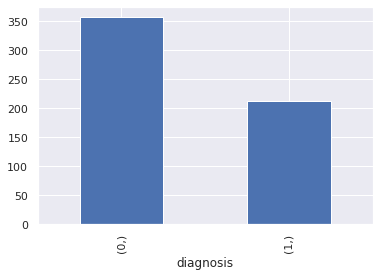

In [72]:
#Check if the data set is balanced. The data set doesn't seem to imbalanced. 

diagnosis = pd.DataFrame(df_cancer.iloc[:,1]) 
diagnosis.value_counts().plot.bar()

Compute the mean and median smoothness and compactness for benign and malignant tumors - do they differ? Explain how you would identify this.

In [73]:
#mean
df_cancer.groupby('diagnosis')[['smoothness_mean', 'compactness_mean']].mean()

,smoothness_mean,compactness_mean
diagnosis,,
0,2.000321,0.021438
1,4.323929,0.032281


In [74]:
#median
df_cancer.groupby('diagnosis')[['smoothness_mean', 'compactness_mean']].median()


,smoothness_mean,compactness_mean
diagnosis,,
0,1.8510,0.01631
1,3.6795,0.02859


The smoothness and compactness are quite different between the Benign and the Malignant tumors. To understand how they differ, it is interesting to plot their distribution. 

In both cases, the mean and median is higher for the Malignant. In the case of the smoothness, the malignant distribution is clearly more skewed than the benign one.

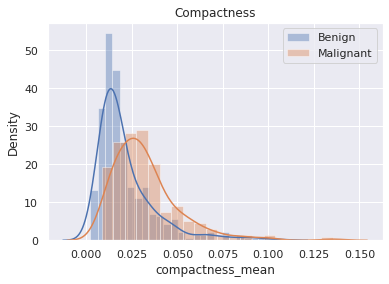

In [75]:
sns.set_theme()
#sns.color_palette("cubehelix", as_cmap=True)
sns.distplot(df_cancer[df_cancer["diagnosis"]== 0]['compactness_mean'], label = 'Benign')
sns.distplot(df_cancer[df_cancer["diagnosis"]== 1]['compactness_mean'], label = 'Malignant')
plt.title('Compactness')
plt.legend()

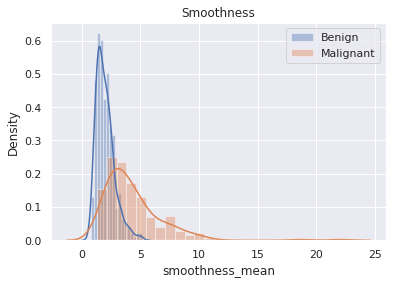

In [76]:
sns.distplot(df_cancer[df_cancer["diagnosis"]== 0]['smoothness_mean'], label = 'Benign')
sns.distplot(df_cancer[df_cancer["diagnosis"]== 1]['smoothness_mean'], label = 'Malignant')
plt.title('Smoothness')
plt.legend()

Write a function to generate bootstrap samples of the data

In [77]:
def bootstrap_sample(df,sample):
   if isinstance(df, pd.DataFrame):
     if isinstance(sample, int):
       if len(df) > 0:
          size = sample/len(df)
          return df.sample(frac = size,replace = True)
  

In [78]:
bootstrap_sample(df_cancer,5)

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,area_mean,area_sd_error,area_worst,smoothness_mean,smoothness_sd_error,smoothness_worst,compactness_mean,compactness_sd_error,compactness_worst,concavity_mean,concavity_sd_error,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
559,925291,0,11.51,23.93,74.52,403.5,0.09261,0.1021,0.11120,0.04105,0.1388,0.06570,0.2388,2.9040,1.936,16.970,0.008200,0.02982,0.05738,0.012670,0.01488,0.004738,12.48,37.16,82.28,474.2,0.1298,0.2517,0.3630,0.09653,0.2112,0.08732
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.1023,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.550,0.005903,0.03731,0.04730,0.015570,0.01318,0.003892,18.98,34.12,126.70,1124.0,0.1139,0.3094,0.3403,0.14180,0.2218,0.07820
474,911391,0,10.88,15.62,70.41,358.9,0.10070,0.1069,0.05115,0.01571,0.1861,0.06837,0.1482,0.5380,1.301,9.597,0.004474,0.03093,0.02757,0.006691,0.01212,0.004672,11.94,19.35,80.78,433.1,0.1332,0.3898,0.3365,0.07966,0.2581,0.10800
156,8711202,1,17.68,20.74,117.40,963.7,0.11150,0.1665,0.18550,0.10540,0.1971,0.06166,0.8113,1.4000,5.540,93.910,0.009037,0.04954,0.05206,0.018410,0.01778,0.004968,20.47,25.11,132.90,1302.0,0.1418,0.3498,0.3583,0.15150,0.2463,0.07738
517,916838,1,19.89,20.26,130.50,1214.0,0.10370,0.1310,0.14110,0.09431,0.1802,0.06188,0.5079,0.8737,3.654,59.700,0.005089,0.02303,0.03052,0.011780,0.01057,0.003391,23.73,25.23,160.50,1646.0,0.1417,0.3309,0.4185,0.16130,0.2549,0.09136


**Exploratory Analysis**

Identify 2-3 variables that are predictive of a malignant tumor.
Display the relationship visually and write 1-2 sentences explaining the relationship.

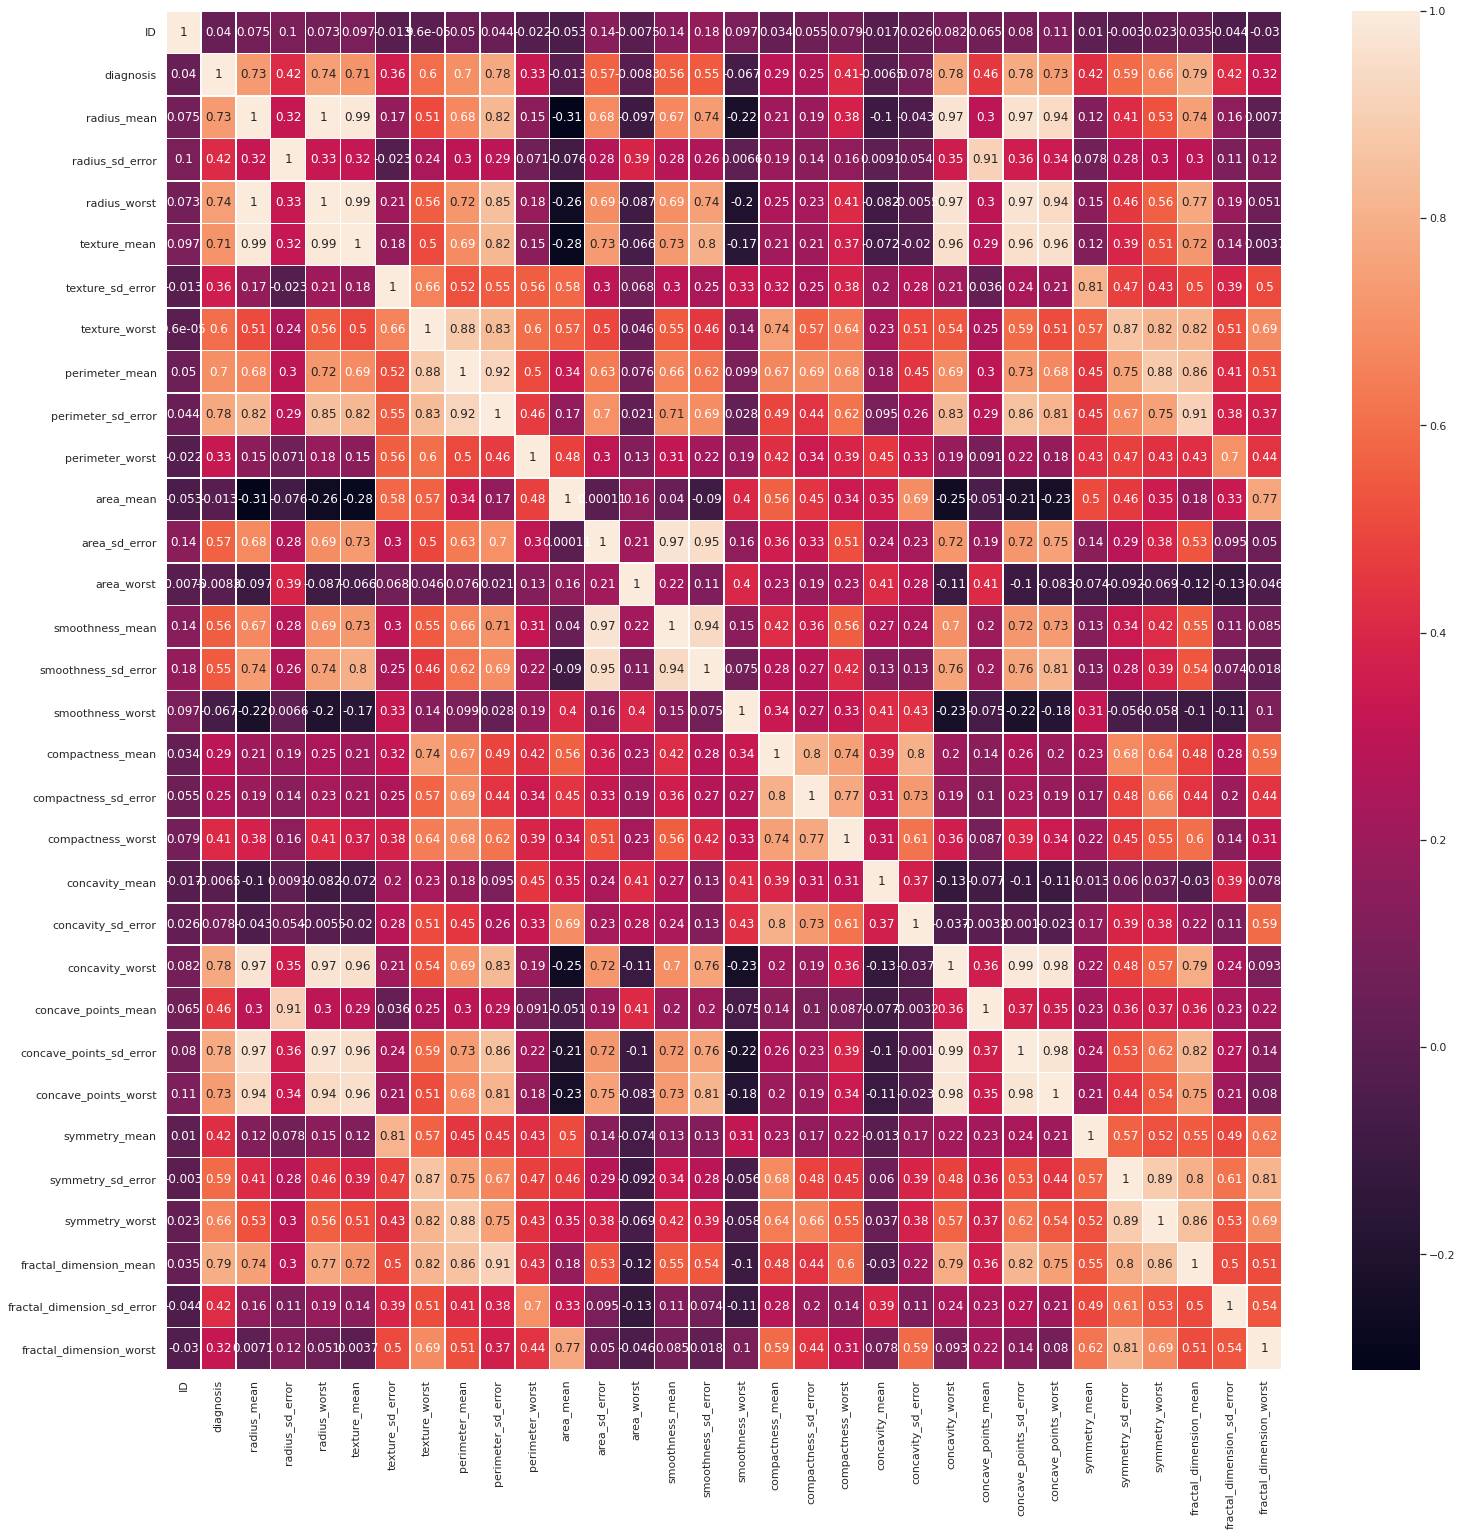

In [79]:
#Using the heatmap to find correlation
corr_df_cancer = df_cancer.corr()
fig, ax = plt.subplots(figsize=(25,25)) 
sns.heatmap(corr_df_cancer, xticklabels=corr_df_cancer.columns, yticklabels=corr_df_cancer.columns, annot=True, linewidths=.5, ax=ax)

There are too many variables, another method is necessary to find the top 3 most predictive variables. The Chi Square test for feature selection is a good alternative. 

concave_points_worst, texture_mean, smoothness_sd_error are the most predictive features.

In [80]:
C, pval=chi2(X, y)                           
sorted_features = X.iloc[:,C.argsort()]
C_df = pd.DataFrame(C, X.columns)
C_df.columns = ['Chi']
sorted_features = C_df.sort_values(by = 'Chi', axis = 0)
selected_feature_idx = C.argsort()[-3:][::-1]
selected_features_df=X.iloc[:,selected_feature_idx]
print ("The top 3 predictive features")
print(selected_features_df.columns)

The top 3 predictive features
Index(['concave_points_worst', 'texture_mean', 'smoothness_sd_error'], dtype='object')


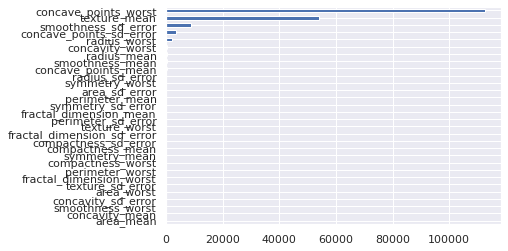

In [81]:
# Visualization
sorted_features.plot( kind = "barh", legend=None)

##Modeling

In [82]:
# 70% training and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) 

In [83]:
#Scaling
sc = StandardScaler()
scaledX_train = sc.fit_transform(X_train)
scaledX_test = sc.fit_transform(X_test)

###The two models chosen are k-nearest neighbors and Random Forest.

k-nearest **neighbors**: good choice for a baseline algorithm because there is no model behing, it's just using the data around, using the right amount of data.

random forest: not as powerful as xgboost but still powerful, interprateble and easy to train




####K-Nearest Neighbors

The first step in the KNN algorithm is to get the right value of K to use. For that, the elbow method is employed.

In [84]:
#Calculate error_rate for various number of clusters
error_rate = []
y_test_knn = y_test['diagnosis'].to_numpy()
y_test_knn = y_test_knn.reshape(171,1)


for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 pred_i = pred_i.reshape(171,1)
 error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

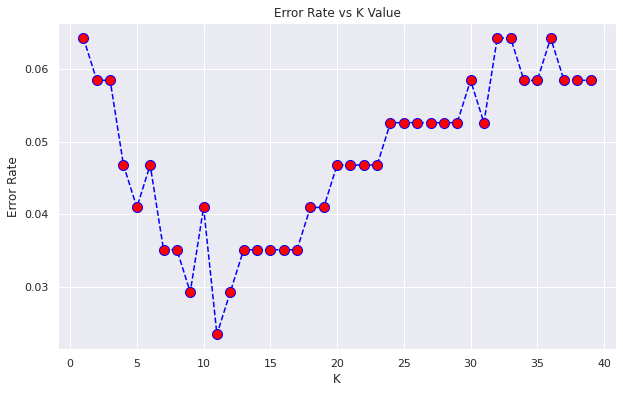

In [85]:
#Print the error_rate to observe the elbow and select K
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

The optimal value for K is 11. After 11, the graph of the error rate increases.

It is now time to retrain the model with the optimal value and evaluate its performance.

In [86]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))

print(classification_report(y_test,pred))

[[107   1]
 [  3  60]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       108
           1       0.98      0.95      0.97        63

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



To avoid overfitting with KNN, it is important to take K with a big enough value. If the value becomes too high, it leads to underfitting. The elbow method is a way to deal with this issue.

Feature importance is not defined for the KNN model.

The best way to estimate feature importance is by taking the sample to predict on, and computing its distance from each of its nearest neighbors for each feature (call these neighb_dist). Then do the same computations for a few random points (call these rand_dist) instead of the nearest neighbors. Then for each feature, you take the ratio of neighb_dist / rand_dist, and the smaller the ratio, the more important that feature is.

####Random Forest

In [87]:
#Grid Search with cross validation to find the best parameters
randomforest = RandomForestClassifier(random_state=23)

param_grid = {
    'bootstrap': [True],
    'max_depth': [2,3,4,6],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4,8,12],
    'n_estimators': [10,50,100,150,200]
}

optimum_grid_search = GridSearchCV(estimator = randomforest, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
optimum_grid_search.fit(scaledX_train, y_train)
optimum_grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  2.3min finished


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 100}

In [88]:
#The precedent step gives the optimal parameters. 
#The prediction is now done with these parameters
rf_best_search = optimum_grid_search.best_estimator_
y_pred = rf_best_search.predict(scaledX_test)

print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

[[107   1]
 [  4  59]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       108
           1       0.98      0.94      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



Random Forest are quite resistant to overfitting. But the deeper the trees, the more likely it becomes to overfit. Controlling the depth of tree is a way to fight overfitting.

Randon Forest is a good algorithm to get the feature importance.

rank | feature name

1   | fractal_dimension_mean

2   |     perimeter_sd_error

3    |  concave_points_worst

In [89]:
features_importance = DataFrame({'Column': X_train.columns, 'coef_weights':np.abs(rf_best_search.feature_importances_)}).sort_values(ascending = False, by = 'coef_weights')
features_importance.reset_index(drop=True, inplace=True)

print("Top 3 important features:")
features_importance['Column'].head(3)

Top 3 important features:


0    fractal_dimension_mean
1        perimeter_sd_error
2      concave_points_worst
Name: Column, dtype: object

####Comparing the two models

In the classic case of cancer, models should be compared based on the recall of the Malignant tumors. It is important to get a low number of False Negatives to be able to save lives.

recall_malignant(KNN) = 0.95
recall_malignant(Random Forest) = 0.94

The selected algorithm is KNN. But there is more than performance. It is easier to analyze and explain the results of random forest, which might be a key factor for healcare analysis.

##Explanation

###To Technical Audiences


*   Size of the data: the data set is quite small, getting more data should be a priority
*   Domain knowledge: It could help for the feature selection and for the outliers. Without domain knwodlege, it is hard to understand what is normal from what shouldn't be a value. Getting the help of an expert would be a next step.


*   Other Algorithms: XGBoost and Ensemble method were not used. XGBoost is famous for overperforming on this kind of data set.


*   Data set unbalanced: The data set contains slightly more Benign. SMOTE could be used.



###To Non-Technical Audiences

Write a short summary of your analysis, explaining how your model works and how it performs.
Briefly explain the factors that contributed to malignant vs benign tumor identification.

The goal of the project is to develop a predictor for cancer tumor.

Data science project follows a well defined plan. 

The first step is to analyse the data for any quality issue. In this project, the quality seems ok. 

The second step is to explore the data with basic statistics and graph to get a first understanding at the features that would allow to differientate between the two types of tumor. Smoothness, compactness, concave_points_worst and texture_mean seems to be important

The third step is training the models. The two models selected are KNN and Random Forest.

The idea of the K Nearest Neighbours is simple. When a new tumor is needed to be diagnosed, the K tumors with the most similar characteristics are used to predict which type it is. The new tumor will be diagnosed the same as the majority of its neighbours.

The idea of the Random Forest is to combine different decision tree. A decision tree is a flowchart like structure in which each internal node represents a test and each leaf represents a diagnosis. The idea of the random forest is to build multiple decision tree, each with a subset of the features. This allow to avoid overfitting.


The last step is to compare the models and select the best one. In the case of cancer, the idea is to focus on predicting cancer and making sure not to predict any cancer as non cancer. This is the most costly mistake we could make. In our case, that means to focus on recall for Malignent tumor. KNN has a better recall than Randon Forest, this is why KNN is a better model for predicting. But predicting power is not everything. Understanding the model can be important for reserchear or doctors. The Random Forest can easily gives which are the most important features to predict a type of tumor. Concave_points_worst, texture_mean, smoothness_sd_error are the most predictive features.


# Part 2: Feedback

## Student Sample 1

###Code

####Bug

**Bug 1**
*   from sklearn import LinearRegression

The correct way to import it is:

*   from sklearn.linear_model import LinearRegression

**Bug 2**


*   from sklearn.cross_validation import cross_val_score

The correct way to import it is:

*   from sklearn.model_selection import cross_val_score

**Bug 3**


*   Data is not defined

The way to solve it is to give the same name to the data imported and the data used. The naming convention is usually df for a dataframe followed by the use of the data.
*   df_train = pd.read_csv('/content/part-2-data.train.csv')
*   x1 = df_train.SalaryNormalized


**Bug 4 and 5**

scores = cross_val_score(model, x2, x1, cv=1, scoring='mean_absolute_error')

The correct way is:


*   neg_mean_absolute_error should be used instead of mean_absolute_error
*   cv = 2 or above. cv is a cross validation split, the data needs to be split at least in 2 different subsets. 






####Library




The libraries should all be called at the beginning of the code.


A library shouldn't be called twice

*   from sklearn.cross_validation import cross_val_score


A library shouldn't be called if it's not being used


*   from sklearn.cross_validation import train_test_split








####Variable

The name of the variables are important. When possible, it is interesting to follow the standard. The name of the variables are useful for two things


*   For the programmer to understand his code better as he is working and not to be lost.
*   For any other person who will need to read his code, colleagues or future person in charge of his code. 

x1,x2 should be y,X for instance. 



####Comments

It is important to comment the text for the programmer coming back to his code if there is any bug and for the colleagues.


*   What is the overall goal of the code
*   What is more in details the goal of each section of the code.

For instance in the set up model, it is interesting to add even one line why the linear regression is chosen. 


###Methodology

Data science project has some well defined steps. It is important to understand them and know when it is possible to go to the next one.

**Data Quality**
Checking the data quality is essential before starting modeling.
Data quality includes data visualisation, checking the basic statistics, printing some examples of the data to get an understing of what is being maanipulated.

**Data Preparation**
Data preparation is made of 


*   Dealing with the outliers
*   Scale the data
*   Encoding categorical variables
*   Relationships in the data

> Finding the correlation between the variables for instance using a heatmap.
> Keeping only one variable among the correlated variables

**Train, test and validation set**

Split the input data into 3 data sets, train, test and validation set.

**Train the model**

The performances should be visualised.

**Evaluate the model**




###Conceptual understanding

The idea of the project is executed but the student can work on two aspects.


**Code**

It needs to be understood that the code is not only made for the student but in real life, it is going to belong to a company. To be useful to a company, a code needs to be readable by other people such as colleague. That is possible using comments and standard choices of variable names.

Understing library is also a key aspect, especially in data science. It is good to read the documentation of the library to understand the different parameters and what value they should take.

**Data Science**

The student needs to understand the workflow of a data science project, data preparation and model evaluation.

The cv=1 in the cross_val_score seems to show a lack of understanding of the model evaluation. 

A regression model works better using more features. In this case, to predict the salary, other interesting features could be Title, LocationNormalized and Company.

## Student Sample 2

###Code

####Bug

**Bug 1**

from sklearn.cross_validation import cross_val_score

The correct way to import it is:

from sklearn.model_selection import cross_val_score


**Bug 2**

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

The correct way is:


*   neg_mean_absolute_error should be used instead of mean_absolute_error



####Library

import numpy as np
The numpy library is imported but not used. This is not part of the good practice.

####Comments

The comments are a bit short. For instance, # Load data could become Load training data. By writing comments, the goal is to explain to another person the code. Usually explaining allow ourself to realize our own mistakes and to correct them. In this case, if the comment is about the training data, where are the testing data?

###Methodology

Data science project has some well defined steps. It is important to understand them and know when it is possible to go to the next one. Data Quality Checking the data quality is essential before starting modeling. Data quality includes data visualisation, checking the basic statistics, printing some examples of the data to get an understing of what is being maanipulated.

**Data Preparation **

Data preparation is made of

Dealing with the outliers
Scale the data
Encoding categorical variables
Relationships in the data
Finding the correlation between the variables for instance using a heatmap. Keeping only one variable among the correlated variables

**Train, test and validation set**
Split the input data into 3 data sets, train, test and validation set.

**Train the model **

The performances should be visualised.

**Evaluate the model**

###Conceptual understanding

The work is pretty well done, the convention on naming are well respected. There are 2 aspects to work on:


**Code**

It needs to be understood that the code is not only made for the student but in real life, it is going to belong to a company. To be useful to a company, a code needs to be readable by other people such as colleague. That is possible using comments and standard choices of variable names.

Understing library is also a key aspect, especially in data science. It is good to read the documentation of the library to understand the different parameters and what value they should take.

**Data Science**

The student needs to understand the workflow of a data science project, data preparation and model evaluation.


A regression model works better using more features. In this case, to predict the salary, other interesting features could be Title, LocationNormalized and Company.

This student can try using different algorithms to extend his knowledge.